# Decision Trees

Decision trees are a supervised learning algorithm used for both classification and regression tasks. In this assignment we are going to take a look at applying them to classification, which is the task for which they were originally developed. One of the key properties of decision trees is that you can use them for problems where you have numerical and also categorical input features. The decision tree you will be making will be based on the *ID3* algorithm. After building our own *ID3* tree, we will then use scikit-learn to explore numerical decision trees and some possibilities for improving them.

## Predicting heart disease 

The data set we will be using for this assignment contains heart disease diagnosis results from 4 different hospitals, and is included with the zip file. Take a look at the `heart-disease.names` file, which contains a description of the data set. The file also gives an explanation for the values of the different variables, so when our tree is complete we can interpret the decision rules created by the algorithm. 

Some variables included here, like *#9 cp: chest pain type*, with 4 labels for different types of chest pain, are clearly categorical. Then there are variables like *#12 chol: serum cholestoral in mg/dl*, containing the concentration of cholesterol, an obvious numeric value. The ability to handle both of these types of data is something not many other machine learning algorithms can do effectively, so in theory a decision tree should be perfect for this data.

The cell below combines the 4 data files from different hospitals into a single data frame. It also cleans up the missing values by simply dropping any rows that contain missing values. Lastly, it separates out the target variable, i.e. the feature we're trying to predict with the decision tree, from the rest of the data set. Here the target variable is the actual diagnosis of heart disease, which is set to either `True` or `False` for each patient.

In [1]:
import pandas as pd

file_names = ['va', 'hungarian', 'switzerland', 'cleveland']
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang',
                'oldpeak', 'slope', 'ca', 'thal', 'num']

# Read in all the different data files into a list of DataFrames
data_files = [pd.read_csv(f'data/processed.{fn}.data', header=None, names=column_names) for fn in file_names]

# Combine all the DataFrames into a single DataFrame
df = pd.concat(data_files, ignore_index=True)
# Force conversion to numeric values
df = df.apply(pd.to_numeric, errors='coerce')
# Remove missing or unconverted values
df = df.dropna()

# Target variable is in the last column
target_var = df.columns[-1]
# Convert target values to True or False
df[target_var] = df[target_var] > 0

# Separate target from input features
data = df.drop(target_var, axis=1)
labels = df[target_var]

display(df)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
28,56.0,1.0,4.0,120.0,100.0,0.0,0.0,120.0,1.0,1.5,2.0,0.0,7.0,True
405,47.0,1.0,4.0,150.0,226.0,0.0,0.0,98.0,1.0,1.5,2.0,0.0,7.0,True
617,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,False
618,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,True
619,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,True
915,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,True
916,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,True
917,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,True


### Dividing the data

As a last preprocessing step we'll do a couple of divisions of the data, starting with sklearn's `train_test_split()`, which will create a training and testing set, randomly divided *70/30* from the full data set.

We will also need to divide the training data and test data into categorical and numerical features, as the basic ID3 algorithm only works with categorical features (which is what we'll start with). This could be done manually by taking a good look at the description file `heart-disease.names`, but it can also be done by counting the amount of unique values present for a feature. We could estimate that a categorical feature will probably have no more than 10 different unique categorical values, while it seems very likely that there are more than 10 different numerical values for a numerical feature in the data.

Using this criterion, both the training and test data are further split into sets of categorical and numeric features. The categorical part of the training data is displayed below.

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.3, random_state=10)

# Set the threshold for the maximum numberof values for a categorical feature
cat_threshold = 10
# Create a mask for all data columns with categorical values according to the threshold
cat_features = [len(np.unique(data[col])) < cat_threshold for col in data.columns]
# Reverse the mask to get all numerical columns
num_features = np.logical_not(cat_features)

# Select categorical features and convert to ints
train_data_cat = train_data.loc[:, cat_features].astype(int)
# Select numerical features and convert to floats
train_data_num = train_data.loc[:, num_features].astype(float)

test_data_cat = test_data.loc[:, cat_features].astype(int)
test_data_num = test_data.loc[:, num_features].astype(float)

display(train_data_cat)

,sex,cp,fbs,restecg,exang,slope,ca,thal
690,1,4,0,2,0,1,2,6
827,0,3,0,0,0,1,0,3
909,1,4,0,0,1,3,0,6
804,1,2,0,0,1,2,3,6
635,0,3,0,0,0,1,0,3
...,...,...,...,...,...,...,...,...
772,1,4,0,2,0,2,3,3
739,1,3,0,0,1,2,0,3
630,1,2,0,0,0,1,0,7
741,1,1,1,2,0,2,1,3


### Assignment 1: Entropy

There are quite a few different definitions of what entropy is; all of them relate to the notion of chaos / order in a system, but the exact definition strongly depends on the context in which the term is used. Most commonly the term refers to thermodynamic entropy, where it describes the number of possible configurations a thermodynamic system can have in a specific state. This is related to the idea of a universal entropy, as used in Asimov's classic short story [The Last Question](http://multivax.com/last_question.html). For decision trees we need the information theoretic entropy, or Shannon entropy, which says something about the amount of information contained in a distribution of data. The more ordered or one-sided the distribution is, the less bits we would need on average to express the exact distribution.

We will use this measure of entropy to compare the results of decision tree splits to see which is the "most informative". For the heart disease problem there are now only 2 class labels we are considering, `True` if the patient has a heart disease diagnosis and `False` otherwise. For a 2 class problem, the entropy is defined as:

$$\phi(p) = −p\ log_2(p) − (1 − p)\ log_2(1 − p)$$

where $p$ is the ratio between the labels for class 1 and class 2. 

First, write a `ratio` function to compute $p$. The function should, given a list of boolean values as class labels, return the ratio of `True` labels in the list, e.g.

* A ratio of $1.0$ would indicate the list only contained `True`,
* a ratio of $0.0$ would mean there were only `False` labels,
* and $0.5$ would be a half `True` and half `False`.

Next, using this `ratio` function to compute $p$, we can compute the actual entropy. However, there is one case that is a little tricky; when $p=0$, meaning there are no labels are `True`, actually computing the value $log_2(0)$ would then (correctly) result in a math error. Luckily, the whole term  $-0\ log_2(0)$, can also just be defined as having the value $0$ (as it is multiplied by $0$).

Write the function `entropy_sub` to compute the value of the log product ($-p\ log_2(p)$), making sure to return $0$ in the case that $p = 0$. Finally, combine the functions `ratio` and `entropy_sub` to compute the `entropy` $\phi$ of a list of boolean class labels. Try to reuse the same `entropy_sub` function for *both* halves of the entropy equation, so your code doesn't produce an error for the second half, in the case $p = 1$, either.

If your functions are correct, the plot below should look familiar.

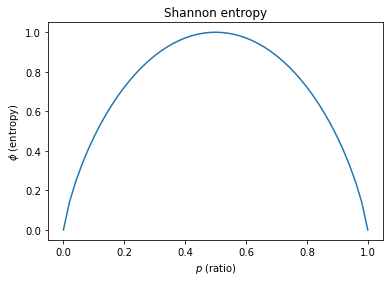

In [3]:
%matplotlib inline

import math
import matplotlib.pyplot as plt

def ratio(labels):
    '''
    function computes ratio: the number of True booleans in a list / length of list.
    '''

    p = sum(labels) / len(labels)
    
    return p

def entropy_sub(p):
    '''
    function computes two parts of the entropy formula and returns these parts seperately.
    '''
    
    # return  0  in the case that p = 0
    if p == 0:
        sub1 = 0
        sub2 = 0
    
    # return  1  in the case that p = 1
    elif p == 1:
        sub1 = 0
        sub2 = 0
        
    # compute log_product in other cases
    else:
        log_part = np.log2(p)
        sub1 = -p * log_part
        
        # compute other part of entropy
        log_part = np.log2((1-p))
        sub2 = (1-p) * log_part
    
    
    return sub1, sub2
    

def entropy(labels):
    
    # compute p
    p = ratio(labels)
    
    # compute entropy_sub
    sub1, sub2 = entropy_sub(p)
    
    # compute entropy
    entropy = sub1 - sub2
    
    return entropy

# construct 50 different lists of labels
N = 50

# compute the ratio and entropy for each list
ratios, entropies = [], []
for i in range(N+1):
    
    # Add `i` times True and `N-i` times False to the list
    label_list = i*[True] + (N-i)*[False]
    
    # Compute the ratio for that list
    ratios.append(ratio(label_list))
    
    # Compute the entropy for that list
    entropies.append(entropy(label_list))

plt.plot(ratios, entropies)
plt.xlabel("$p$ (ratio)")
plt.ylabel("$\phi$ (entropy)")

plt.title("Shannon entropy")
plt.show()


### Assignment 2: Splitting data

Next, we'll work on some of the functions to actually create the data set splits. **A split is a grouping of samples in a data set by each of the unique values for _one_ of the features.**

As an example, let's say we have the following small sample data set for the PlayTennis problem:

<br><img src="src/tennis.png" width="45%"><br>

Here there are 4 features, *Outlook*, *Temperature*, *Humidity* and *Wind*, recorded for each *Day*. The target label we're trying to predict is whether or not it is a good day to *PlayTennis*.

Let's start by separating out the label from the other features:

<br><img src="src/tennis_labels.png" width="80%"><br>

There are 4 possible features to split the data set on. The result of a split should be a **dictionary**, where each key is the feature value being split on, and the value is the corresponding subset of the data or the labels.

Let's say we split on the feature *Outlook* first, the resulting split would then look as follows:

<br><img src="src/outlook_split.png" width="80%"><br>

As an intermediate step, before creating the actual split dictionaries, you should create a dictionary containing boolean masks to select each of these subsets. These masks can then be applied to create the splits of both the data and the labels.

For the example split above, this would then be that intermediate masking dictionary:

<br><img src="src/outlook_mask.png" width="80%"><br>

First, write the function `masks_for_split`, which takes a `dataframe` and the name of the `feature` for which to create the split. The function should return a dictionary with each of the unique values of the feature as keys, and the corresponding boolean masks as values. The example above should be the result of calling 

    outlook_mask = masks_for_split(tennis_data, 'Outlook')
    
You can use [np.unique](https://numpy.org/doc/stable/reference/generated/numpy.unique.html) to find all the unique values for that feature. Creating a boolean mask array is described [here](https://numpy.org/doc/stable/user/basics.indexing.html#boolean-or-mask-index-arrays).

Next, write the function `apply_split`, which takes a `dataframe` and a dictionary of `split_masks`. The function should apply each mask to the dataframe and return the resulting split dictionary. For the example above, the call creating the split would be

    outlook_split_data = apply_split(tennis_data, outlook_mask)
    outlook_split_labels = apply_split(tennis_labels, outlook_mask)
 
Use the provided tennis data below to test whether both your functions work correctly, as this will be a lot easier to do the verification with than the full heart disease data set.

In [4]:
def masks_for_split(dataframe, feature):
    '''
    function creates a dictionary with each of the unique values of the feature as keys, 
    and the corresponding boolean masks as values. 
    '''
   
    # get unique features in column
    unique_values = np.unique(dataframe[feature])
    
    # place features in dictionary as keys
    split_masks = {}
    for unique_value in unique_values:
        mask = dataframe[feature] == unique_value
        split_masks[unique_value] = mask
    
    return split_masks
    

def apply_split(dataframe, split_masks):
    '''
    function takes a dataframe and a dictionary of split_masks. 
    The function should apply each mask to the dataframe and return the resulting split dictionary
    '''
    
    # declare empty dict to fill in
    split_dict = {}
    
    # look for specific feature
    for feature in split_masks:
        
        # create mask for specific feature, apply to dataframe and store in dict
        mask = list(split_masks[feature])
        split_dict[feature] = dataframe[mask]
    
    return split_dict


tennis_data = pd.DataFrame([
    ['Sunny', 'Hot', 'High', 'Weak'], ['Sunny', 'Hot', 'High', 'Strong'], ['Overcast', 'Hot', 'High', 'Weak'],
    ['Rain', 'Mild', 'High', 'Weak'], ['Rain', 'Cool' ,'Normal', 'Weak'], ['Rain', 'Cool', 'Normal', 'Strong']],
    index=['D1', 'D2', 'D3', 'D4', 'D5', 'D6'], columns = ['Outlook', 'Temperature', 'Humidity', 'Wind'])

tennis_labels = pd.DataFrame([
    [False], [False], [True], [True], [True], [False]],
    index=['D1', 'D2', 'D3', 'D4', 'D5', 'D6'], columns = ['PlayTennis'])

display(tennis_data)
display(tennis_labels)

outlook_mask = masks_for_split(tennis_data, "Outlook")
outlook_split_data = apply_split(tennis_data, outlook_mask)
outlook_split_labels = apply_split(tennis_labels, outlook_mask)

,Outlook,Temperature,Humidity,Wind
D1,Sunny,Hot,High,Weak
D2,Sunny,Hot,High,Strong
D3,Overcast,Hot,High,Weak
D4,Rain,Mild,High,Weak
D5,Rain,Cool,Normal,Weak
D6,Rain,Cool,Normal,Strong


,PlayTennis
D1,False
D2,False
D3,True
D4,True
D5,True
D6,False


### Assignment 3: Information gain

Information Gain measures how much the entropy changes from making a specific split, i.e. the gain in predictability of the data as a result of making a distribution based on a specific feature. When a set of target labels $S$ is split on a feature (or attribute) $A$, two or more new lists are created, each with their own entropy. Combining the resulting entropies from a split into new subsets $S_v$ is done as a weighted sum. The Information Gain is the difference between the old entropy of $S$ and the weighted sum of the new entropies resulting from the split on attribute $A$:

$$IG(S, A) = \phi(S) - \sum_{v \in Values(A)} \frac{|S_v|}{|S|} \phi(S_v) $$

Here $S$ is the set of target labels and $S_v$ is the subset of $S$ where the value of the attribute $A$ is equal to $v$. $|S|$ and $|S_v|$ are the size of the original label set and the subset respectively. Therefore, $|S|$ is always equal to the number of samples before the split (as each sample has exactly one label) and $|S_v|$ is equal to the size of the subset of data where the value of the attribute $A$ is equal to $v$.

Continuing the tennis example from before, in order to compute the information gain of splitting the data on *Outlook*, we'll need to look at what effect the split has on the labels we're trying to predict. For the split on *Outlook*, this would look like:

<br><img src="src/outlook_split_labels.png" width="80%"><br>

Each of the values of the dictionary here corresponds with one subset $S_v$, so $S_{sunny}$, $S_{overcast}$, and $S_{rain}$ respectively. The full set $S$ is just the union of these 3 subsets together.

Constructing this dictionary with the split labels can be simply done by applying the split mask to the labels, as before: 

    outlook_split_labels = apply_split(tennis_labels, outlook_mask)

Next, write a function `information_gain()`, which should implement $IG(S, A)$ and reuse your `entropy()` function from before to do so. The function argument `split_labels` is a dictionary with each of the split labels, like the `outlook_split_labels` example above. More precisely, `split_labels` is a dictionary with attribute values $v$ as the keys, mapping to the subset of labels $S_v$, corresponding to the samples that contain that value $v$.

*Hint:* You can use [pd.concat](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html) to "glue" the different subsets together in order to reconstruct $S$.


In [5]:
def information_gain(split_labels):
    '''
    function implements  𝐼𝐺(𝑆,𝐴),  using the entropy() function from before.
    input is is a dictionary with attribute values  𝑣  as the keys, 
    mapping to the subset of labels  𝑆𝑣 , corresponding to the samples that contain that value  𝑣.
    
    '''

    # create a list of seperate values and concatenate the dfs for every value
    list_values = split_labels.values()
    original_df = pd.concat(list_values, ignore_index = True)
    
    # calculate original entropy
    original_entropy = entropy(original_df)
    
    # set IG to original entropy (S)
    IG = original_entropy
    
    # calculate entropy for every label and update IG
    for label in split_labels:
        sub_entropy = entropy(split_labels[label])
        IG -= (len(split_labels[label]) / len(original_df)) * sub_entropy
        
    return IG
        
IG = information_gain(apply_split(labels, masks_for_split(data, 'thal')))
    

In [6]:
assert abs(information_gain(apply_split(labels, masks_for_split(data, 'thal'))) 
           - 0.2136994692625539) < 1e-10, "Information Gain for 'thal' is incorrect" 
assert abs(information_gain(apply_split(labels, masks_for_split(data, 'ca'))) 
           - 0.1779347528954177) < 1e-10, "Information Gain for 'ca' is incorrect" 

### Assignment 4: ID3

Below is the code to create a complete DecisionTree object using the *ID3* algorithm. A part of the code has already been provided and documented. Start by reading the `__init__()` function to learn all the relevant variables that are stored for this class.

Write the function `determine_best_split()`, which should consider all possible splits of the data, making use of the `masks_for_split()`, `apply_split()` and `information_gain()`, and find the best split. This function should update `self.info_gain`, `self.split_feature`, `self.split_data` and `self.split_labels` according to that best split, i.e. the split that provided the largest information gain.

Next, complete the function `create_subtrees()`. Most of this function has already been written; you'll only need to add two more lines to complete the function. Even if it is quite a small function, it isn't trivial, and is one of the most important steps of the algorithm. Each subset of the data from the split is actually used to create another `DecisionTree`, which can then be split further again. Each of these subtrees are stored in `self.branches`, where the key is the attribute value for that part of the split and the value is the new decision subtree. This repeated step is what actually builds a complex decision tree, using the split results to create a new tree with another split, and so on. Start by reading the code that has already been given, and make sure that you understand it, before adding the remaining two lines. 

With these functions in place, the decision tree will actually already completely build itself! All that is now left to do, is to make sure this tree can also classify new samples. These new samples will always be a single row from a DataFrame, which is called a Series, with the same structure as the training data. Complete the function `classify()`, which should return the predicted class label, so either True or False, given a new sample. Again, there are only two lines you'll need to add here, but this short function is still complicated enough. The basic case for this function is to return the most common class label if this node is a leaf node or if the value of the feature that was split on does not occur in the branches. Otherwise, the decision tree will look up the subtree in the branch corresponding to the value of the feature that it was split on, and return the classification predicted by that subtree.

Lastly, write the `validate()` function, which should take a dataframe `test_data` and classify every row in the DataFrame. The function should return the accuracy (i.e. percentage correct) of these classifications as compared to the actual class label contained in `test_labels`. For the heart disease data set, this decision tree with the default threshold of $0.1$ should have about *93%* accuracy on the training data and *82%* on the testing data.


In [7]:

class DecisionTree(object):
    '''
    class used to to create a complete DecisionTree object using the ID3 algorithm. 
    '''
    
    def __init__(self, data, labels, thres=0.1):
        '''
        all the relevant variables that are stored for this class.
        '''
        
        # The dataframe containing the samples belonging to this node
        self.data = data
        
        # The corresponding class labels for each of these same samples
        self.labels = labels
        
        # The minimum information gain for a split, below this stop splitting the tree
        self.thres = thres
        
        
        # These next 4 variables will be set by calling determine_best_split()
        
        # The information gain of the split at this node in the decision tree
        self.info_gain = 0
        
        # The feature / attribute that this node was split on
        self.split_feature = None
        
        # The dictionary containing the data split on the values of that feature
        self.split_data = None
        
        # The dictionary containing the labels split on the values of that feature
        self.split_labels = None
        
        # Find the best feature to split on and set the 4 variables above correctly
        self.determine_best_split()
    
    
        # Indicates if the current node is a leaf node, i.e. has no further splits
        self.leaf = self.info_gain < self.thres
        
        # Assign this node the most common class label, either True or False
        self.common_label = ratio(labels) >= 0.5
    
        # Dictionary containing the actual branches of the Decision Tree, where 
        # the keys are different values of the feature that was split on and
        # the values are new subtrees, created with data subsets from the split
        self.branches = {}
        
        # Fill the branches of the decision tree by recursively creating subtrees
        self.create_subtrees()
        
    def determine_best_split(self):
        '''
        function considers all possible splits of the data, making use of the masks_for_split(), 
        apply_split() and information_gain(), and find the best split. function updates
        self.info_gain, self.split_feature, self.split_data and self.split_labels according to that best split.
        '''
        
        for feature in self.data:
            
            # calculate IG
            data_mask = masks_for_split(self.data, feature)
            split_labels = apply_split(self.labels, data_mask)
            IG = information_gain(split_labels)
            
            # update if appropriate:
            if IG > self.info_gain:
                
                # update the feature / attribute that this node was split on
                self.split_feature = feature
                
                # update the dictionary containing the data split on the values of that feature
                self.split_data = apply_split(self.data, data_mask)

                # update the dictionary containing the labels split on the values of that feature
                self.split_labels = split_labels
                
                # update info gain
                self.info_gain = IG

              
    def create_subtrees(self):
        '''
        function creates subtrees
        '''
        
        # If the current node is not a leaf node, continue to split the data
        if not self.leaf:
            
            # Loop through all the different possible values of the best split feature
            for feature_value in self.split_data:
                
                # Retrieve the subset of the data that has this specific feature value
                subset_data = self.split_data[feature_value]
                
                # Get the corresponding subset of the labels for that same feature value
                subset_labels = self.split_labels[feature_value]

                # This creates a new DecisionTree for each branch in the current tree. These new subtrees
                # are created using the subsets of data and labels from the current split. Repeatedly 
                # constructing the subtrees in this ways, the data is split further and further each tree.
                subtree = DecisionTree(subset_data, subset_labels, self.thres)
                
                # Each subtree is stored in the branches dictionary, using the split feature value as the
                # key, so we can always find back the relevant branch for a sample. Each stored subtree
                # can again contain subtrees in its owns branches, and so on, building the tree stucture.
                self.branches[feature_value] = subtree
                
            
    def classify(self, row):
        '''
        function returns the predicted class label, either True or False, given a new sample. 
        '''
        
        # If the current tree is a leaf, just return the most common label
        if self.leaf:
            return self.common_label
        
        # To classify a row from the DataFrame (i.e. a single sample), use the feature that this specific
        # tree was split on and get the corresponding value of that feature from the row / sample.
        split_feature_value = row[self.split_feature]
        
        # If that feature value is not one of the branches in this tree, just treat it as a leaf node
        if split_feature_value not in self.branches:
            return self.common_label
        
        # Else, get the relevant subtree from the branch belonging to the feature value from the row
        # we are currently trying to classify (for the feature on which this specific tree was split).
        subtree = self.branches[split_feature_value]
        
        # Use this subtree, which itself is a DecisionTree instance, to further determine the classification
        # for this sample row, by calling the same function again on the subtree instance and returning its
        # classification for the row.
        return subtree.classify(row)
        
    
    def validate(self, test_data, test_labels):
        '''
        function calls on classify function to classify every row in the DataFrame. 
        The function returns the accuracy (i.e. percentage correct) of these classifications
        as compared to the actual class label contained in test_labels. 
        '''
        
        # set empty variables to calculate accuracy later
        correct = 0
        total = 0
        
        # get test data classification (y_hat) and actual test labels (y)
        for index, row in test_data.iterrows():
            y_hat = self.classify(row)
            y = test_labels[index]
            
            # update variables to calculate accuracy: compare to test_data and test_labels
            if y_hat == y:
                correct += 1
            
            # update total count
            total += 1
        
        # calculate accuracy
        accuracy = correct / total * 100
        
        return accuracy
            
        

tree = DecisionTree(train_data_cat, train_labels)

print(f'Train accuracy: {tree.validate(train_data, train_labels)}')
print(f'Test accuracy: {tree.validate(test_data, test_labels)}')

Train accuracy: 93.77990430622009
Test accuracy: 82.22222222222221


### Assignment 5: Numerical Decision Tree

Now that our Categorical Decision Tree is done, we will take a look at a Numerical Decision tree. As described in the theory videos, it is possible to extend the Categorical Decision Tree to also include numerical boundaries. We could then use this to even select the best Information Gain from *both* the categorical *and* the numerical splits at each node.

However, for now we will focus on a model that can *only* make numerical splits, as that is what the `scikit-learn` library provides straight out of the box: The [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) is a class that can build a decision tree from numerical data, and so we won't have to implement this tree from scratch.

The most important difference between categorical and numerical decision trees is the way the data is split. In categorical data, it is easy to split the tree into the $N$ categories that are present in the data. This is impossible to do in numerical data, as there are infinitely many categories. Categorical Decision trees therefore use binary splits or a so-called split boundary; where with each split we create one branch with values smaller than the boundary, and one branch with values greater than or equal to the boundary.

This boundary for a feature can be determined by trying every possible split boundary available for the set of values. This is done by first sorting the samples and then trying every split half way between two neighbouring values that have different labels. This means there can be as many splits as there are samples, and as such this method is computationally very expensive. An alternative, simpler method that is often used, is trying some amount of random splits for a feature and picking the best random split among them.

Note that repeated binary splits on the same numerical variable can be used to create many different "decision regions" for the same variable. For example, consider a label where you want a variable to be above or equal to 3.4, but below 4.8. Here you would need two splits; a first split with 3.4 as the boundary and then in the "greater equal branch" of that split, another split boundary of 4.8 on that same variable. This means that while the feature that was split on could be ignored in further splits in the case of a Categorical Decision tree, this is not the case for Numerical Decision Trees, and repeated splits on the same variable can actually greatly improve accuracy.

Implement a Numerical Tree Classifier using a `sklearn.tree.DecisionTreeClassifier` and its `fit` and `predict` functions. Train it using the numerical part of the dataset `train_data_num` that was separated out earlier (see the second code cell of this notebook) and print the training and test accuracies. Determining the accuracy can easily be done through the `metrics.accuracy_score` method from the `metrics` module.

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score

# create tree
clf = DecisionTreeClassifier()

# predictions for training data

# fit the data
clf = clf.fit(train_data_num, train_labels)

# use model to predict class of samples
predictions = clf.predict(train_data_num)

# calculate metrics for training data 
accuracy_training = accuracy_score(train_labels, predictions)
    
# predictions for testing data

# use model to predict class of samples
predictions = clf.predict(test_data_num)

# calculate metrics for ttesting data 
accuracy_testing = accuracy_score(test_labels, predictions)


print(f'Train accuracy: {accuracy_training}')
print(f'Test accuracy: {accuracy_testing}')

Train accuracy: 1.0
Test accuracy: 0.6777777777777778


The scikit-learn Decision Trees implementation is specifically intended for numerical features. This might not be immediately obvious, but if we read the documentation on [Decision Trees](https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart) and see what algorithms it uses, we find:

```scikit-learn uses an optimised version of the CART algorithm; however, scikit-learn implementation does not support categorical variables for now.```

Even if it does not actually support categorical data, you can *still* make this implementation work, provided that you give each category a number. **Note: This is not recommended (discouraged even), as this suggests that there is an ordering (the numerical order) to the categorical data.** For many models, saying category 1 is before category 3, and category 2 is somewhere in between them, can really screw up your predictions.

Even though this is not recommended, since our data already has integer numbers for each of the categories we could easily try and see what works. Train a Numerical Tree Classifier using `sklearn.DecisionTreeClassifier` and the categorical data `train_data_cat`, and print the training and test accuracies. Next, train using the complete training data `train_data`, i.e. categorical and numerical combined and also report the training and testing accuracies.

*Note: the linked page on Decision Trees contains more useful information and hints if you plan to use this model on any projects of your own, so it might be worth reading through.*

In [9]:
# TRAIN USING THE CATEGORICAL DATA

# create tree
clf = DecisionTreeClassifier()

# predictions for training data

# fit the data
clf = clf.fit(train_data_cat, train_labels)

# use model to predict class of samples
predictions = clf.predict(train_data_cat)

# calculate metrics for training data 
accuracy_training = accuracy_score(train_labels, predictions)

    
# predictions for testing data

# use model to predict class of samples
predictions = clf.predict(test_data_cat)

# calculate metrics for testing data 
accuracy_testing = accuracy_score(test_labels, predictions)

print(f'Train accuracy: {accuracy_training}')
print(f'Test accuracy: {accuracy_testing}')

Train accuracy: 0.9521531100478469
Test accuracy: 0.8


In [10]:
# TRAIN USING THE COMPLETE DATA

# create tree
clf = DecisionTreeClassifier()

# predictions for training data

# fit the data
clf = clf.fit(train_data, train_labels)

# use model to predict class of samples
predictions = clf.predict(train_data)

# calculate metrics for training data 
accuracy_training = accuracy_score(train_labels, predictions)
    
# predictions for testing data

# use model to predict class of samples
predictions = clf.predict(test_data)

# calculate metrics for testing data 
accuracy_testing = accuracy_score(test_labels, predictions)

print(f'Train accuracy: {accuracy_training}')
print(f'Test accuracy: {accuracy_testing}')

Train accuracy: 1.0
Test accuracy: 0.7333333333333333


### Analysis questions 

Answer these questions about the results. Write your answers below each question in this cell.

**Q1. Why does the training accuracy for numerical splits become 1.0 (i.e. a perfect fit), but remains lower for categorical splits?**

*The numerical split is overfitting. The categorical is not, because the samples can have overlapping features which would cancel each other out which prevents overfitting.*

**Q2. Explain how it is possible that in some cases the testing accuracy using only the categorical variables can be higher than the testing accuracy using the categorical and numeric variables combined. What property of the Decision Tree causes this?**

*The use of numerical features leads to overfitting so if you use both types, you are more likely to overfit due to the use of those numerical featues. This decreases the accuracy. The property of DTC that causes this is that the implementation will continue separating nodes until they are either pure or no more conditions can be set to further improve purity.*

**Q3. While using categorical data as if it is numerical is generally not recommended, in Decision Trees it doesn't seem as problematic. In fact, we could always reproduce a discrete split using a combination of numeric splits on that same variable. Explain how many splits we would need and what the structure might look like.**

*You'd need n-1 splits. In that case, the structure would look something like: a node structure that starts with one node and creates two seperate nodes in the next layer that contain half of the categorical data left. e.g. For 4 categorical features:


                                    n
                                   / \
                                  n    n
                                 /\    /\
                                n  n  n  n
*


### Assignment 6: Preventing overfitting

As we now know, trees learn by beginning with the full training set and greedily adding conditions that maximize each child nodes' label purity. As the tree grows, each node adds another condition resulting in smaller subgroups. In fact, the number of leaf-nodes grows exponentially as we add more depth to the tree and in just a few splits a training set with thousands of examples can be reduced to a set of leaves with sizes around 1-20, which lack statistical validity. Since our implementation will continue separating nodes until they are either pure or no more conditions can be set to further improve purity, it is very probable that we force our tree to overfit.

There are several techniques that deal with tree overfitting. It is possible to prune the tree, for example by removing leaves once the tree is complete, or by preventing it from growing as deep in the first place by setting a threshold on the minimum Information Gain.

Scikit-learn's [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) has several argument options to help prevent overfitting. Probably the easiest to get started with is `min_samples_split`, which sets what the minimum number of samples in a node should be before it can be split. If a node has fewer samples than this number, it will not be split further and the predicted label just becomes the most common label at that node.

Try several values for `min_samples_split` and give a value that definitely still overfits, a value that definitely causes underfitting and the value you think gives the best fit on the data. Report the training and testing accuracy for each.


Text(0.5, 0, 'minimum number of samples required')

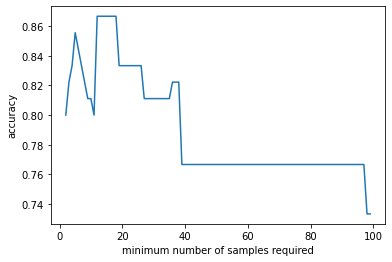

In [11]:
# TRAIN USING THE CATEGORICAL DATA

# create empty lists for plotting
list_training = []
list_testing = []

# create list of possible min_samples_split values
num_list = list(range(2, 100))

for minimum_number in num_list:

    # create tree
    clf = DecisionTreeClassifier(min_samples_split = minimum_number)

    # predictions for training data

    # fit the data
    clf = clf.fit(train_data_cat, train_labels)

    # use model to predict class of samples
    predictions = clf.predict(train_data_cat)

    # calculate metrics for training data 
    accuracy_training = accuracy_score(train_labels, predictions)


    # predictions for testing data

    # use model to predict class of samples
    predictions = clf.predict(test_data_cat)

    # calculate metrics for testing data 
    accuracy_testing = accuracy_score(test_labels, predictions)
    
    list_training.append(accuracy_training)
    list_testing.append(accuracy_testing)

plt.plot(num_list, list_testing)
plt.ylabel("accuracy")
plt.xlabel("minimum number of samples required")
    

**Q4. Which minimum split size gives the best fit on the data? Explain why you choose this value.**

*The outcomes seem to change everytime that I run the cell. But the accuracy consistently seems to be the highest at around 15 based on the ranges that I tried between 2 and 100. Best minimum split size that gives the best fit on the testing data is probably 15. (the plot above is difficult to read but when I decrease the range from 2 to 30 the plot clearly indicates that the best split occurs at split size 15)

I did not bother to check beyond 100 because the accuracy only seems to drop and it would only take up more time and make the data less readable.*

### Assignment 7: Plotting the Decision Tree

Sklearn also comes with a tool that can actually plot the whole decision tree. However, plotting the complete tree would be a bit hard to read, as it wouldn't really fit in the figure. We can again use another `DecisionTreeClassifier` argument to limit the size of the tree. Here using `max_depth` makes the most sense, as we want to uniformly cut the tree at a certain depth for the plot.

Fit a decision tree of a limited depth and call it `d_tree`. The code below will already plot it. Make sure the tree is small enough so you can read off the values in the plot. If not, reduce the `max_depth` further.

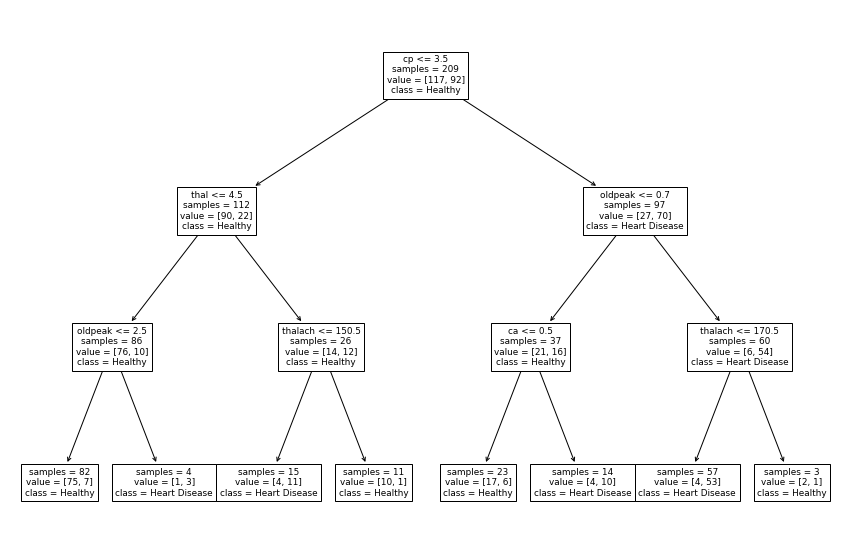

In [12]:
from sklearn import tree
from matplotlib.pyplot import figure

# create tree, max_depth to 3 for readability
d_tree = DecisionTreeClassifier(min_samples_split = 13, max_depth = 3)

# predictions for training data

# fit the data
d_tree = d_tree.fit(train_data, train_labels)

# use model to predict class of samples
predictions = d_tree.predict(train_data)

# calculate metrics for training data 
accuracy_training = accuracy_score(train_labels, predictions)

# predictions for testing data

# use model to predict class of samples
predictions = d_tree.predict(test_data)

# calculate metrics for testing data 
accuracy_testing = accuracy_score(test_labels, predictions)

figure(figsize=(15, 10))
tree.plot_tree(d_tree, feature_names=df.columns.values,
               class_names=['Healthy', 'Heart Disease'], impurity=False);

**Q5. Try to read out the boundaries set in the decision tree. Refer back to the `heart-disease.names` if you don't know what a variable means. What parameters seem to be the best indicators for heart disease?**

*Following the path of the decision tree, it seems that the best indicators for heart disease are: cp (chest pain), with oldpeak, with thalach.* Note that I used all the training data. so the outcome may have been different if I used only categorical or only numerical. 

**Q6. Explain why considering a very reduced version of the tree should still give some insight into the important factors of heart disease.**

*Well, the decision tree splits first on the most important factors. So even with a reduced version, you can get some suggestion of what important factors are in relation to heart disease*

### Assignment 8: Random Forests 

Another method for reducing overfitting is the ensemble approach. In an ensemble approach multiple models are trained on (variations of) the original dataset, and then used to give a combined prediction. A commonly used ensemble method for decision trees is Random Forest. The essence of Random Forest classification is to have many decision trees that have all been trained on a random subset of features with randomly drawn sample rows. These decision trees then all predict on unseen samples and a majority vote is used as the final prediction. This procedure usually leads to better model performance; while the predictions of a single tree are highly sensitive to noise in the training data; the average of many trees trained on very similar data is not.

We will be implementing a simple but effective variant of Random Forest that creates a small sample of all training data and trains several of scikit's `DecisionTreeClassifier`s on a random subset of features. First, we will need to create the forest. Implement `create_forest` that should accept `n_trees`, the number of trees that should be in the forest, and returns a list containing all of the `DecisionTreeClassifier` objects. Check the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) for a way to change the maximum amount of features used in the tree to the square root of the number of features and use it when creating the classifiers. *This is an easy way to limit the number of features used in the classifier and will help to differentiate all the models learned by each of the trees.*

In [13]:
def create_forest(n_trees):
    
    # set empty list
    forest = []
    
    # create opbject for all n trees
    for i in range (n_trees):
        _object = DecisionTreeClassifier(splitter = "random", max_features = "sqrt")
        
        # append to list
        forest.append(_object)
    
    return forest


Now implement the function `train_forest` that accepts a `forest` (a list of `DecisionTreeClassifier` objects) and trains each of the trees with `ratio` samples from `data`. *Training each of the trees on different random subsets of the data will also help to differentiate all the models learned by each of the trees.*

Hint: use the pandas [sample](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) method to create your subsets.

In [14]:
def train_forest(forest, data, labels, ratio = 0.5):
    
    # set empty list for trees
    model_trees = []
    
    for s_tree in forest:
        
        # create sample
        sample = data.sample(frac = ratio)
        
        # fancy indexing to get labels (= get corresponding labels for each sample)
        indeces = sample.index
        label_indeces = labels[indeces]
        
        # fit the data
        model_tree = s_tree.fit(sample, label_indeces)
        
        # add model_tree to list
        model_trees.append(model_tree)

    return model_trees
    

Implement the function `predict_forest` that accepts a `forest` and predicts the target label for the passed `data`.

Hint: since we only have two possible predictions, `True` and `False`, which are equal to 1 and 0 respectively, we can just add all predictions of all trees together, adding 1 or 0 for each. If we then divide the total prediction by the number of trees, we end up with an 'average vote' that can be rounded to be either 1 or 0; `True` or `False`.

In [15]:
def predict_forest(forest, data):

    # set empty variable for sum predictions
    predictions = 0
    
    for tree in forest:
        
        # use model to predict class of samples
        prediction = tree.predict(data)
        
        # add value to total predictions
        predictions += prediction
        
    # calculate average vote
    average_vote = predictions / len(forest)
    
    # create mask for average votes
    mask = average_vote >= 0.5
    
    return mask


Now, create a random forest with 1000 trees, each using only 3 or 4 random features ($\approx \sqrt{13}$) and train each forest with a 50% random sample of the complete training data. Print out the train and testing accuracy. Does this result improve over using just 1 tree?

In [16]:
#  create a random forest with 1000 trees
n_trees = 1000
n_features = 4
forest = create_forest(n_trees)

# train each forest with a 50% random sample of the complete training data
model_trees = train_forest(forest, train_data, labels, ratio = 0.5)

predicted_label_training = predict_forest(forest, train_data)

# calculate metrics for training data 
accuracy_training = accuracy_score(train_labels, predicted_label_training)

# gebruik zelfde forest voor predictions op test data
predicted_label_testing = predict_forest(forest, test_data)
    
# Print out the train and testing accuracy

# calculate metrics for testing data 
accuracy_testing = accuracy_score(test_labels, predicted_label_testing)

print(f'Train accuracy: {accuracy_training}')
print(f'Test accuracy: {accuracy_testing}')



Train accuracy: 1.0
Test accuracy: 0.8555555555555555


In [18]:
# the test accuracy seems to be much higher! 